# Skin lesion classification


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)



First load all necessary packages

In [0]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from Google Drive

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1jR7IDSiMi6K5N1akq1b_wgRatKpx1qLm',
dest_path='./features.csv')
gdd.download_file_from_google_drive(file_id='1ZtQj7L1r0VKf1SHx9rZ7SJ1YlZ2LsnCy',
dest_path='./nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='18W0GVO1LtLDXRBlHKu_-960kR9EZcnAI',
dest_path='./nevus.jpg')
gdd.download_file_from_google_drive(file_id='1P6x4UaHc4yXl4rAoxEYikVxOxpByYRH4',
dest_path='./melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1pQl0qF3ViH_ZibV5tGZ0uPYFhr0ggu1c',
dest_path='./melanoma.jpg')

Then read the data 

In [0]:
## Read data
df = pd.read_csv('./features.csv') # reading data (raw data)
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy, y is labeling
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features, iloc is retributing the elements form matrix (we just select the column and row.)
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))
print(df.iloc[0:10,0].values); # 1st column is numbering of label.
print(df.iloc[0:10,1].values); # 2nd column is name of sample.
print(df.iloc[0:10,2].values); # 3rd column is label of sample (0: healthy, 1:malignant).



Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115
[0 1 2 3 4 5 6 7 8 9]
['IM_000498' 'IM_000617' 'IM_000394' 'IM_000244' 'IM_000599' 'IM_000639'
 'IM_000279' 'IM_000834' 'IM_000483' 'IM_000577']
[0 0 0 0 0 0 0 0 1 0]


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

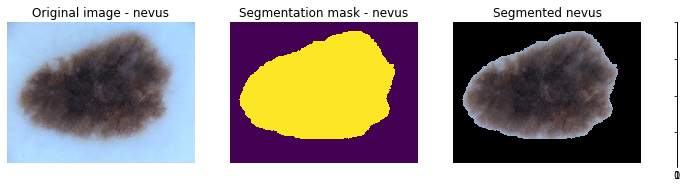

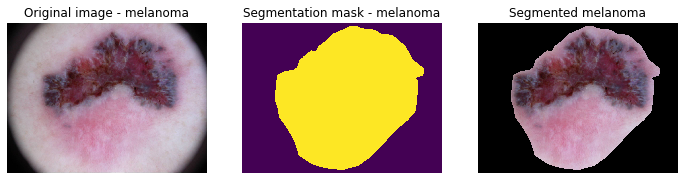

In [0]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread('./nevus.jpg')
nevus_Segmentation = imread('./nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers), binary type
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 4),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")


##

melanoma = imread('./melanoma.jpg')
melanoma_Segmentation = imread('./melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [0]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
#print(indeces)

np.random.shuffle(indeces)
#print(indeces)

Xp=X[indeces]
Yp=y[indeces]


 

it can be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)
Xmean = np.mean(Xp,axis=0) # Compute average
Xstd=np.std(Xp,axis=0)    # Compute standard deviation
X_norm=(Xp-Xmean)/Xstd


Divide the entire data-set into training and test set and use two simple classification algorithms, a linear and a quadratic one... Look at the confusion matrices and comment the results. 

done in 0.01s
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       125
           1       0.43      0.12      0.19        25

    accuracy                           0.83       150
   macro avg       0.64      0.54      0.55       150
weighted avg       0.78      0.83      0.78       150

Normalized confusion matrix
[[0.968 0.032]
 [0.88  0.12 ]]


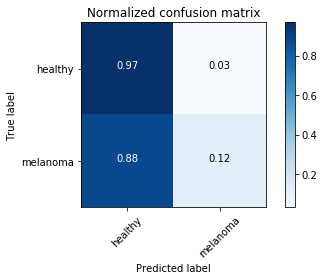

In [0]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, Yp, test_size=0.25, random_state=42)

# Fitting LDA
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.2fs" % (time() - t0))
print(classification_report(y_test, y_pred))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

done in 0.04s
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       125
           1       0.29      0.16      0.21        25

    accuracy                           0.79       150
   macro avg       0.57      0.54      0.54       150
weighted avg       0.75      0.79      0.77       150

Normalized confusion matrix
[[0.92 0.08]
 [0.84 0.16]]


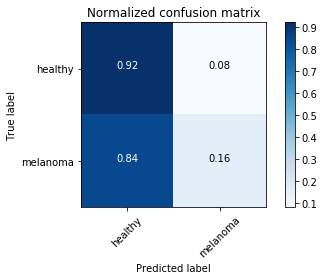

In [0]:
# Fitting QDA
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print("done in %0.2fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Apply Cross Validation

In [0]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,Xp, Yp,cv=4)
print("done in %0.2fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,Xp, Yp,cv=4)
print("done in %0.2fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,Xp, Yp,cv=4)
print("done in %0.2fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting LDA
done in 0.03s
 Average and std CV score : 0.8049069588277997 +- 0.03012394566617464
Fitting QDA
done in 0.04s
 Average and std CV score : 0.8165403647569522 +- 0.02771035384222478
Fitting K-nearest neighbour
done in 0.09s
 Average and std CV score : 0.7550171859490051 +- 0.0188570456708192


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value.


2 0.8333333333333334
Normalized confusion matrix
[[0.984 0.016]
 [0.92  0.08 ]]


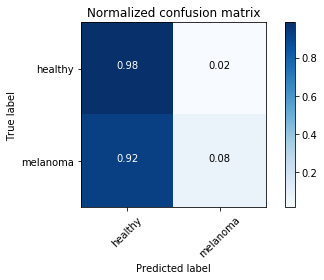

3 0.8133333333333334
Normalized confusion matrix
[[0.936 0.064]
 [0.8   0.2  ]]


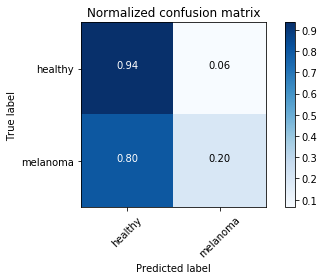

4 0.8266666666666667
Normalized confusion matrix
[[0.976 0.024]
 [0.92  0.08 ]]


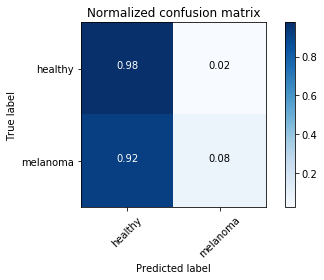

5 0.8333333333333334
Normalized confusion matrix
[[0.968 0.032]
 [0.84  0.16 ]]


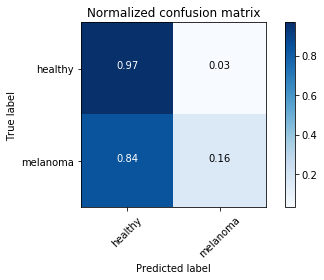

6 0.8266666666666667
Normalized confusion matrix
[[0.976 0.024]
 [0.92  0.08 ]]


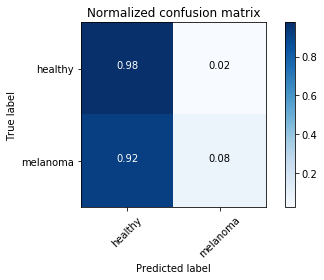

7 0.84
Normalized confusion matrix
[[0.968 0.032]
 [0.8   0.2  ]]


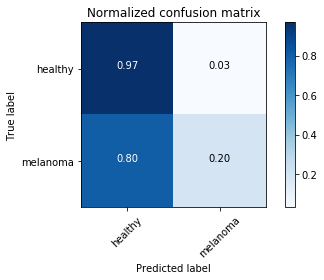

8 0.84
Normalized confusion matrix
[[0.992 0.008]
 [0.92  0.08 ]]


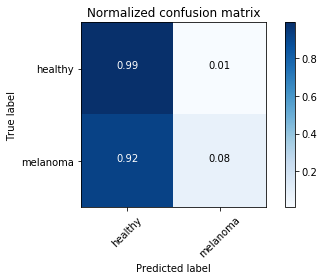

9 0.8466666666666667
Normalized confusion matrix
[[0.984 0.016]
 [0.84  0.16 ]]


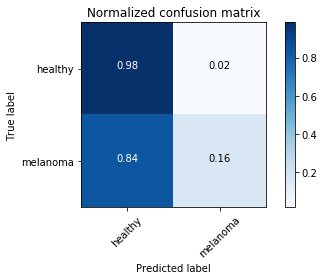

In [0]:
from sklearn.metrics import accuracy_score
for i in range(2,10):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  print(i,accuracy_score(y_test, y_pred))

  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  # Plot normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
  plt.show()





Possible solutions could be found in these two web-pages: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter, and try other scoring functions with at least one of the 3 previous models.
-
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html and try at least one naive random over-sampling (look at the following code...).

In [0]:
from sklearn.metrics import balanced_accuracy_score
for i in range(2,10):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  print("When k is equal to %s ,the balanced accuracy score is %2f" % (i,balanced_accuracy_score(y_test, y_pred)))


When k is equal to 2 ,the balanced accuracy score is 0.532000
When k is equal to 3 ,the balanced accuracy score is 0.568000
When k is equal to 4 ,the balanced accuracy score is 0.528000
When k is equal to 5 ,the balanced accuracy score is 0.564000
When k is equal to 6 ,the balanced accuracy score is 0.528000
When k is equal to 7 ,the balanced accuracy score is 0.584000
When k is equal to 8 ,the balanced accuracy score is 0.536000
When k is equal to 9 ,the balanced accuracy score is 0.572000


In [0]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(Xp, Yp, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 319), (1, 319)]


After retesting KNN on this new data-set.The results are better.



In [0]:
##try KNN with new data-set
from sklearn.metrics import balanced_accuracy_score
for i in range(2,10):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_resampled, y_resampled)
  y_pred = neigh.predict(X_test)
  print("When k is equal to %s ,the balanced accuracy score is %2f" % (i,balanced_accuracy_score(y_test, y_pred)))

When k is equal to 2 ,the balanced accuracy score is 0.574925
When k is equal to 3 ,the balanced accuracy score is 0.652861
When k is equal to 4 ,the balanced accuracy score is 0.658321
When k is equal to 5 ,the balanced accuracy score is 0.625753
When k is equal to 6 ,the balanced accuracy score is 0.618035
When k is equal to 7 ,the balanced accuracy score is 0.597515
When k is equal to 8 ,the balanced accuracy score is 0.587914
When k is equal to 9 ,the balanced accuracy score is 0.610693


use more advanced techiques such as SVM



In [0]:
# Fitting Linear SVM on original data
print("Fitting Linear SVM to the original training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X_train,y_train,cv=5,scoring='accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(), Lsvm_score.std() ))

Fitting Linear SVM to the original training set
done in 0.211s
 Average and std CV score : 0.7910368807626191 +- 0.009283431909986707


Suppose that there are overlapping classes, we need to set the hyper-parameter C. Look at the previous code for K-NN and find the best C value.

When C is equal to 0.001 ,the balanced accuracy score is 0.628953
Normalized confusion matrix
[[0.78915663 0.21084337]
 [0.53125    0.46875   ]]


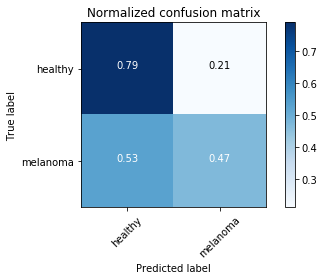

When C is equal to 0.01 ,the balanced accuracy score is 0.523532
Normalized confusion matrix
[[0.07831325 0.92168675]
 [0.03125    0.96875   ]]


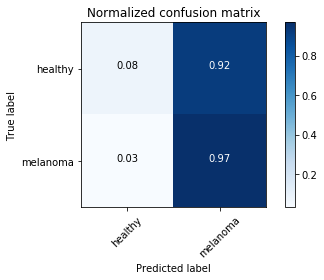

When C is equal to 0.1 ,the balanced accuracy score is 0.509036
Normalized confusion matrix
[[0.01807229 0.98192771]
 [0.         1.        ]]


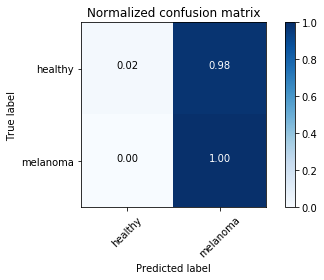

When C is equal to 1 ,the balanced accuracy score is 0.500000
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


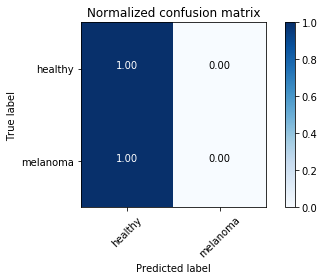

When C is equal to 2 ,the balanced accuracy score is 0.500000
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


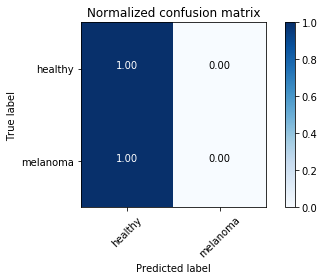

When C is equal to 3 ,the balanced accuracy score is 0.515625
Normalized confusion matrix
[[1.      0.     ]
 [0.96875 0.03125]]


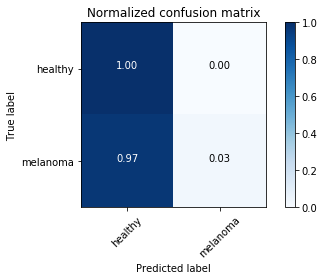

When C is equal to 4 ,the balanced accuracy score is 0.500000
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


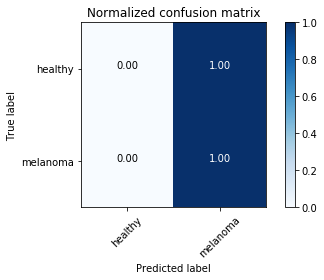

When C is equal to 5 ,the balanced accuracy score is 0.536333
Normalized confusion matrix
[[0.72891566 0.27108434]
 [0.65625    0.34375   ]]


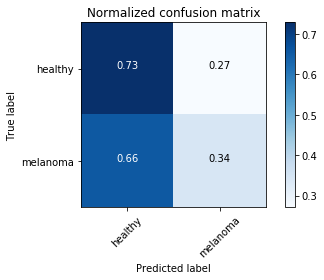

When C is equal to 6 ,the balanced accuracy score is 0.500000
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


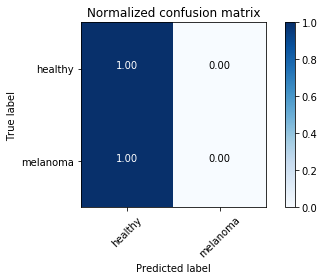

When C is equal to 7 ,the balanced accuracy score is 0.531815
Normalized confusion matrix
[[0.96987952 0.03012048]
 [0.90625    0.09375   ]]


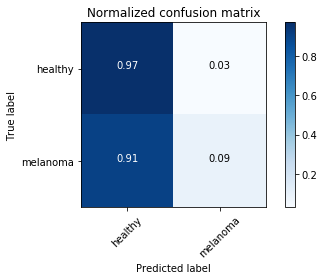

When C is equal to 8 ,the balanced accuracy score is 0.503012
Normalized confusion matrix
[[0.0060241 0.9939759]
 [0.        1.       ]]


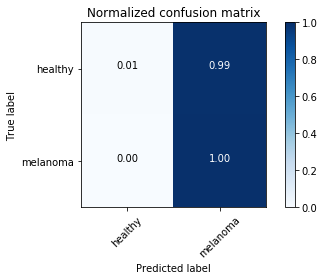

When C is equal to 9 ,the balanced accuracy score is 0.500000
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


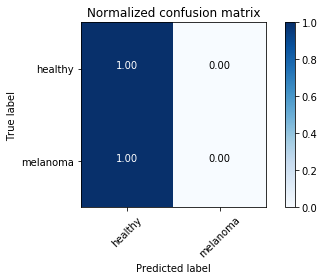

When C is equal to 10.0 ,the balanced accuracy score is 0.500000
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


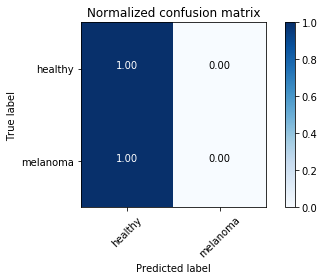

The best C is 0.001000


In [0]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
p=[]
for i in p_grid_lsvm['C']:
  Lsvm = LinearSVC(C=i,class_weight='balanced')
  Lsvm.fit(X_train, y_train)
  y_pred = Lsvm.predict(X_test)
  print("When C is equal to %s ,the balanced accuracy score is %2f" % (i,balanced_accuracy_score(y_test, y_pred)))
  p.append(balanced_accuracy_score(y_test, y_pred))

  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_pred)
  # Plot normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
  plt.show()
C=p_grid_lsvm['C'][p.index(max(p))]
print("The best C is %3f" %C)

Try to use the previous SVM code but on the over-sampled data.


In [0]:
# Fitting Linear SVM on over-sampled data
print("Fitting Linear SVM to the resampled training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X_train,y_train,cv=5,scoring='accuracy')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(), Lsvm_score.std() ))

Fitting Linear SVM to the resampled training set
done in 0.208s
 Average and std CV score : 0.7861294733552118 +- 0.010869532552849122


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

In [0]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf,X_train,y_train, cv=outer_cv)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train,y_train)
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))


Fitting Non-linear SVM to the training set
done in 15.898s
Average and std Nested Cv score : 0.7935185185185185 +- 0.046542657264951375
Best Score: 0.7935323383084577
Best params: {'C': 0.1, 'gamma': 0.0005}


#Dimensionality reduction#

In [0]:
# Test at least one reduction technique with a linear and non-linear SVM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=20)
X_r = lda.fit(Xp, Yp).transform(Xp)

# LDA with linear SVM
print('apply LDA to a linear SVM')
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm,X_r,Yp,cv=5,scoring='accuracy')
print(" Average and std CV score : {0} +- {1}".format(Lsvm_score.mean(), Lsvm_score.std() ))

# LDA with non-linear SVM
print('apply LDA to a non-linear SVM')
NLsvm=SVC(kernel='rbf', class_weight='balanced')
NLsvm_score = cross_val_score(NLsvm,X_r,Yp,cv=5,scoring='accuracy')
print(" Average and std CV score : {0} +- {1}".format(NLsvm_score.mean(), NLsvm_score.std() ))


apply LDA to a linear SVM
 Average and std CV score : 0.76 +- 0.05093568929978707
apply LDA to a non-linear SVM
 Average and std CV score : 0.735 +- 0.03551212625443751


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(30, 2 - 1) = 1 components.
  ChangedBehaviorWarning)


To test the importance of the single features.


The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. 

In [0]:
# Implement forward feature selection and/or backward feature selection
# with a linear and/or non-linear SVM

#Implement backward featur selection with a linear SVM
Xp=X[indeces]
k=30
while (k>20):
  p=[] #empty list to store accuracy
  for i in range(20):
    X_reduction=np.delete(Xp, [i], axis=1)
    Lsvm = LinearSVC(class_weight='balanced')
    Lsvm_score = cross_val_score(Lsvm,X_reduction,Yp,cv=5,scoring='accuracy')
    p.append(Lsvm_score.mean())
  r=p.index(max(p)) #select redundant feature by accuracy 
  Xp=np.delete(Xp, [r], axis=1)
  k=Xp.shape[1]
print('number of feature is reduced to %d'%k)
print('current accuracy with linear SVM is %f'%max(p))



number of feature is reduced to 20
current accuracy with linear SVM is 0.810000
